## Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings('ignore')
import json
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Loading the dataset

In [3]:
fake_df=pd.read_csv("dataset/Fake.csv")
true_df=pd.read_csv("dataset/True.csv")

<b>Adding the labels

In [4]:
fake_df['label']=0
true_df['label']=1

In [5]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


<b>Removing unnecessary columns

In [6]:
fake_df.drop(columns=["title","date","subject"],inplace=True)
true_df.drop(columns=["title","date","subject"],inplace=True)

In [7]:
true_df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


<b>Concatenating both dataframes into one

In [8]:
df=pd.concat([fake_df,true_df],ignore_index=True)

<b>Removing duplicated values

In [9]:
df.duplicated().sum()

6251

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

<b>Final information about the dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38647 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38647 non-null  object
 1   label   38647 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 905.8+ KB


## Custom Tokenizer

In [12]:
with open('english_contractions.json', 'r') as f:
    contraction_dict = json.load(f)

In [13]:
print(contraction_dict)

{"'aight": 'alright', "ain't": 'are not', "amn't": 'am not', "aren't": 'are not', "can't": 'cannot', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "daren't": 'dare not', "daresn't": 'dare not', "dasn't": 'dare not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "d'ye": 'do you', "e'er": 'ever', "everybody's": 'everybody is', "everyone's": 'everyone is', 'finna': 'fixing to', "g'day": 'good day', 'gimme': 'give me', "giv'n": 'given', 'gonna': 'going to', "gon't": 'go not', 'gotta': 'got to', "hadn't": 'had not', "had've": 'had have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he had', "he'll": 'he shall', "he's": 'he has', "he've": 'he have', "how'd": 'how did', 'howdy': 'how do you do', "how'll": 'how will', "how're": 'how are', "how's": 'how has', "i'd": 'I had', "i'd've": 'I would have', "i'll": 'I shall', "i'm": 'I am', "i'm'a": 'I am about to', "i'm'o": 'I am going to', 'innit': 'is it not', "i've

In [14]:
def normalize_contractions(text):
    """
    Normalize English contractions in a single sentence.
    """
    return _normalize_contractions_text(text, contraction_dict)

def _normalize_contractions_text(text, contractions):
    new_token_list = []
    token_list = text.split()
    for word in token_list:
        first_upper = word[0].isupper()
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper() + replacement[1:]
            replacement_tokens = replacement.split()
            new_token_list.extend(replacement_tokens)
        else:
            new_token_list.append(word)
    return " ".join(new_token_list).strip()


In [15]:
def normalize_repeats(word):
    """
    Collapse excessive character repetition and append <REPEAT:n> for words with elongations.
    Keeps word readable and tokens informative.
    Example:
        'sooooo'     → 'so <REPEAT:5>'
        'looooving'  → 'loving <REPEAT:4>'
    """
    # Pattern: detect a repeated character (3+ times) anywhere in word
    match = re.search(r'(.)\1{2,}', word)
    
    if not match:
        return word  # No exaggerated repeat

    char = match.group(1)
    repeat_start = match.start()
    repeat_len = len(match.group(0))
    
    # Collapse repeat to a single char, remove extras
    collapsed = re.sub(r'(.)\1{2,}', r'\1', word)
    
    return f"{collapsed} <REPEAT:{repeat_len}>"


In [16]:
emoticons=re.compile(r'(:\)|:\(|:D|:P|<3|;\)|:\'\(|:-\)|:-\(|:-D|:-P|:-O)')

def tokenizer(text):
    text = text.lower()
    text = normalize_contractions(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#[\w-]+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers

    text = emoticons.sub(lambda m: f'{m.group(0)}', text)  # Preserve emoticons
    text = re.sub(r'([!?,.;:()"\'])', r' \1 ', text)  # Separate punctuation
    text = re.sub(r"\s+", " ", text).strip()

    raw_tokens = text.split()
    tokens = []
    normalized_tokens = [normalize_repeats(tok) for tok in raw_tokens]
    return normalized_tokens


In [17]:
sample_text = "sooooo happy!!! I'm looooving this soooo much!!!"
print(tokenizer(sample_text))


['so <REPEAT:5>', 'happy', '!', '!', '!', 'I', 'am', 'loving <REPEAT:4>', 'this', 'so <REPEAT:4>', 'much', '!', '!', '!']


In [18]:
broken_contractions = {}

for contraction, expansion in contraction_dict.items():
    cleaned = contraction.replace("’", "'")  # Normalize apostrophes
    if "'" in cleaned:
        parts = cleaned.split("'")
        if len(parts) == 2:
            pre, post = parts
            broken_contractions[(pre, post)] = expansion
        elif cleaned.endswith("n't"):
            # Special case: "couldn't" -> ("couldn", "t")
            prefix = cleaned[:-3]  # remove n't
            broken_contractions[(prefix + "n", "t")] = expansion


In [19]:
print(broken_contractions)

{('', 'aight'): 'alright', ('ain', 't'): 'are not', ('amn', 't'): 'am not', ('aren', 't'): 'are not', ('can', 't'): 'cannot', ('', 'cause'): 'because', ('could', 've'): 'could have', ('couldn', 't'): 'could not', ('daren', 't'): 'dare not', ('daresn', 't'): 'dare not', ('dasn', 't'): 'dare not', ('didn', 't'): 'did not', ('doesn', 't'): 'does not', ('don', 't'): 'do not', ('d', 'ye'): 'do you', ('e', 'er'): 'ever', ('everybody', 's'): 'everybody is', ('everyone', 's'): 'everyone is', ('g', 'day'): 'good day', ('giv', 'n'): 'given', ('gon', 't'): 'go not', ('hadn', 't'): 'had not', ('had', 've'): 'had have', ('hasn', 't'): 'has not', ('haven', 't'): 'have not', ('he', 'd'): 'he had', ('he', 'll'): 'he shall', ('he', 's'): 'he has', ('he', 've'): 'he have', ('how', 'd'): 'how did', ('how', 'll'): 'how will', ('how', 're'): 'how are', ('how', 's'): 'how has', ('i', 'd'): 'I had', ('i', 'll'): 'I shall', ('i', 'm'): 'I am', ('i', 've'): 'I have', ('isn', 't'): 'is not', ('it', 'd'): 'it wo

In [20]:
def fix_broken_contractions(tokens, broken_dict):
    i = 0
    new_tokens = []
    while i < len(tokens):
        if i + 1 < len(tokens) and (tokens[i], tokens[i + 1]) in broken_dict:
            expansion = broken_dict[(tokens[i], tokens[i + 1])].split()
            new_tokens.extend(expansion)
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    return new_tokens


In [21]:
text=df['text'].iloc[0]
tokens = tokenizer(text)
print("Original tokens:", tokens)
fixed_tokens = fix_broken_contractions(tokens,broken_contractions)
print("Fixed tokens:", fixed_tokens)

Original tokens: ['donald', 'trump', 'just', 'couldn', 't', 'wish', 'all', 'americans', 'a', 'happy', 'new', 'year', 'and', 'leave', 'it', 'at', 'that', '.', 'instead', ',', 'he', 'had', 'to', 'give', 'a', 'shout', 'out', 'to', 'his', 'enemies', ',', 'haters', 'and', 'the', 'very', 'dishonest', 'fake', 'news', 'media', '.', 'the', 'former', 'reality', 'show', 'star', 'had', 'just', 'one', 'job', 'to', 'do', 'and', 'he', 'couldn', 't', 'do', 'it', '.', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', ',', 'i', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', ',', 'supporters', ',', 'enemies', ',', 'haters', ',', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', ',', 'a', 'happy', 'and', 'healthy', 'new', 'year', ',', 'president', 'angry', 'pants', 'tweeted', '.', 'will', 'be', 'a', 'great', 'year', 'for', 'america', '!', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', ',', 'i', 'want', 'to', 'wish', 'all', 'of', 'my

## Custom Lemmatizer

<b>Rule Based Mini POS Tagger</b>
1. Some common verbs without any specific rule are set aside
2. Words ending in -ing, -ed : Verbs
3. Words ending in -ly,-ous,-ful,-ive,-able,-ic : Adjective
4. Words ending in -ness,-ment,-ion : Nouns
5. The REPEAT: tokens : Meta
6. For tokens not yet tagged, iterate through a list of suffix patterns (e.g., "-ing", "-ed", "-ly") and assign the associated POS tag if a match is found.
7. If the token starts with an uppercase letter and is still untagged: Proper Noun
8. If the token starts with a lowercase letter and is still untagged: Noun
9. If no rule applies: Other

In [22]:
common_POS={
    "is": "VERB",
    "are":"VERB",
    "has": "VERB",
    "have":"VERB",
    "had": "VERB",
    "was":"VERB",
    "were": "VERB",
    "did":"VERB",
    "be": "VERB",
    "been":"VERB",
    "do": "VERB",
    "does":"VERB",
    "did": "VERB"
}

suffix_list = [
    (r'.+ing$', 'VERB'),
    (r'.+ed$', 'VERB'),
    (r'.+ly$', 'ADV'),
    (r'.+ous$', 'ADJ'),
    (r'.+ful$', 'ADJ'),
    (r'.+ive$', 'ADJ'),
    (r'.+able$', 'ADJ'),
    (r'.+ic$', 'ADJ'),
    (r'.+ness$', 'NOUN'),
    (r'.+ment$', 'NOUN'),
    (r'.+tion$', 'NOUN'),
    (r'.{3,}s$', 'NOUN'),   
]


<b>Function for POS tagging

In [23]:
def pos(tokens): 
    tagged = []
    for t in tokens:
        tag = None
        lower = t.lower()

        # Detect <REPEAT:n> 
        if re.fullmatch(r'<REPEAT:\d+>', lower):
            tag = "META"

        if not tag and lower in common_POS:
            tag = common_POS[lower]

        if not tag:
            for p, suffix in suffix_list:
                if re.fullmatch(p, lower):
                    tag = suffix
                    break

        if not tag and t[0].isupper():
            tag = "PROPER NOUN"

        if not tag and t[0].islower():
            tag = "NOUN"

        if not tag:
            tag = "OTHER"

        tagged.append((t, tag))

    return tagged

<b> Some general english irregular words which do not follow suffix rules

In [24]:
IRREGULARS = {
    "ran": "run",
    "running": "run",
    "swam": "swim",
    "gone": "go",
    "better": "good",
    "worse": "bad",
    "fought": "fight",
    "bought": "buy",
    "ate": "eat",
    "children": "child",
    "mice": "mouse"
}

<b>Lemmatizer Design</b>


Verb Lemmatization:
1. Removed “-ing”, ”-es” and “-ed” suffixes to retrieve the base verb (e.g., “running” → “run”).
2. Removing -ing and -es only if word is longer than 4 letters to prevent sing from becoming s and similar
cases


Noun Lemmatization:
1. Replace “-ies” endings with “y” (e.g., “stories” → “story”).
2. Remove “-es” from words ending in “-es”.
3. Remove a final “-s” from words that are not “ss” and are longer than three letters (e.g., “cats” → “cat”
but “boss” remains “boss”).


Adjective/Adverb Lemmatization:
1. Remove “-est” from words ending in “-est” (if the word is longer than five letters).
2. Remove “-er” from words ending in “-er” (if the word is longer than four letters).
e.g. biggest” → “big”

In [25]:
def lemmatizer(tagged_tokens):
    lemmas = []
    for word, pos in tagged_tokens:
        lower = word.lower()

        if lower in IRREGULARS:
            lemma = IRREGULARS[lower]
        else:
            lemma = lower

            if pos == "VERB":
                if re.fullmatch(r'.+ing$', lower) and len(lower) > 4:
                    lemma = re.sub(r'ing$', '', lower)
                elif re.fullmatch(r'.+ed$', lower):
                    lemma = re.sub(r'ed$', '', lower)
                elif re.fullmatch(r'.+es$', lower) and len(lower) > 4:
                    lemma = re.sub(r'es$', '', lower)

            elif pos == "NOUN":
                if re.fullmatch(r'.+ies$', lower):
                    lemma = re.sub(r'ies$', 'y', lower)
                elif re.fullmatch(r'.+es$', lower):
                    lemma = re.sub(r'es$', '', lower)
                elif lower.endswith('s') and not lower.endswith('ss') and len(lower) > 3:
                    lemma = re.sub(r's$', '', lower)

            elif pos == "ADJ":
                if re.fullmatch(r'.+est$', lower) and len(lower) > 5:
                    lemma = re.sub(r'est$', '', lower)
                elif re.fullmatch(r'.+er$', lower) and len(lower) > 4:
                    lemma = re.sub(r'er$', '', lower)
        
        lemmas.append(lemma)

    return lemmas


## Final Preprocessing Pipeline

In [26]:
def clean_apostrophes(text):
    # Convert curly quotes to straight quotes
    text = text.replace("’", "'").replace("`", "'")
    return text

<b> Final pipeline calling all the functions

In [27]:
def process_pipeline(text):
    if isinstance(text, list):  
        text = " ".join(text)
    text = clean_apostrophes(text)
    tokens = tokenizer(text)
    tokens=fix_broken_contractions(tokens,broken_contractions)
    tagged = pos(tokens)
    lemmas = lemmatizer(tagged)
    return ' '.join(lemmas)

# Applying to entire dataset
df['processed_text'] = df['text'].apply(process_pipeline)


<b> Dataset after preprocessing

In [28]:
df.head(10)

,text,label,processed_text
0,Donald Trump just couldn t wish all Americans ...,0,donald trump just could not wish all american ...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,"on friday , it was reveal that former milwauke..."
3,"On Christmas day, Donald Trump announced that ...",0,"on christma day , donald trump announc that he..."
4,Pope Francis used his annual Christmas Day mes...,0,pope franci us his annual christma day message...
5,The number of cases of cops brutalizing and ki...,0,the number of cas of cop brutaliz and kill peo...
6,Donald Trump spent a good portion of his day a...,0,donald trump spent a good portion of his day a...
7,In the wake of yet another court decision that...,0,in the wake of yet another court decision that...
8,Many people have raised the alarm regarding th...,0,many people have rais the alarm regard the fac...
9,Just when you might have thought we d get a br...,0,just when you might have thought we had get a ...


## Feature Extraction

<b>1. Bag Of Words using CountVectorizer

In [29]:
vectorizer = CountVectorizer(
    stop_words='english',
    min_df=3,
    max_df=0.8
)

X_bow = vectorizer.fit_transform(df['processed_text'])
feature_names = vectorizer.get_feature_names_out()

In [30]:
print("Vocabulary sample:", feature_names[450:500])

Vocabulary sample: ['adolescence' 'adolescent' 'adolf' 'adolfo' 'adolph' 'adonia' 'adopt'
 'adopter' 'adoption' 'adoptive' 'ador' 'adorable' 'adoration' 'adore'
 'adorn' 'adrenaline' 'adrian' 'adriana' 'adriatic' 'adrienne' 'adrift'
 'adroit' 'ads' 'adulation' 'adult' 'adulterat' 'adulterer' 'adulterous'
 'adultery' 'adulthood' 'adulyadej' 'adumim' 'advanc' 'advance'
 'advancement' 'advantag' 'advantage' 'advantageous' 'advent' 'adventist'
 'adventur' 'adventure' 'adventurer' 'adventurism' 'adventurous'
 'adversarial' 'adversary' 'adverse' 'adversely' 'adversity']


<b>2. TF-IDF — Term Frequency-Inverse Document Frequency

In [31]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

## Model Training

<b>Splitting the dataset for both, Bag of Words and TF-IDF

In [32]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['label'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

<b>Implementing Naive Bayes on both sets

In [33]:
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

<b>Implementing SVM on both sets

In [34]:
svm_bow = LinearSVC()
svm_bow.fit(X_train_bow, y_train)

svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)


LinearSVC()

## Evaluation and Visualization

In [35]:
results=[]

In [36]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    

    # Compute probabilities or decision scores for ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        print(f"{name} model does not support probability or decision scores needed for ROC curve.")
        return

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

<b> Metrics of Naive Bayes using Bag of Words


Naive Bayes (BoW) Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3500
           1       0.96      0.95      0.95      4230

    accuracy                           0.95      7730
   macro avg       0.95      0.95      0.95      7730
weighted avg       0.95      0.95      0.95      7730



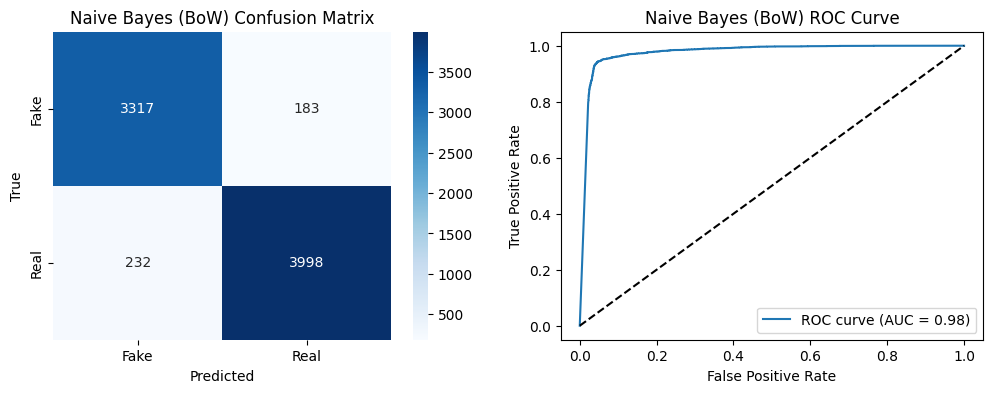

In [37]:
metrics=evaluate(nb_bow, X_test_bow, y_test, "Naive Bayes (BoW)")
results.append(metrics)

<b> Metrics of Naive Bayes using TF-IDF


Naive Bayes (TF-IDF) Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3500
           1       0.92      0.96      0.94      4230

    accuracy                           0.94      7730
   macro avg       0.94      0.93      0.94      7730
weighted avg       0.94      0.94      0.94      7730



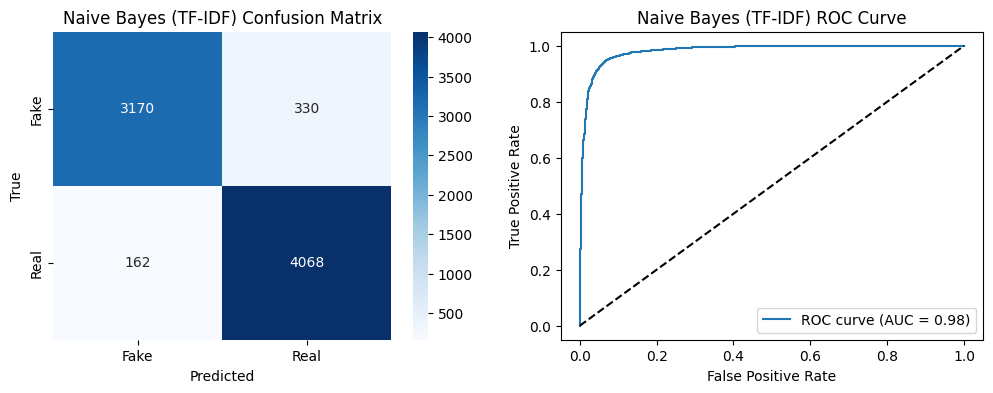

In [38]:
metrics=evaluate(nb_tfidf, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)")
results.append(metrics)

<b> Metrics of SVM using Bag of Words


SVM (BoW) Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3500
           1       0.99      1.00      0.99      4230

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



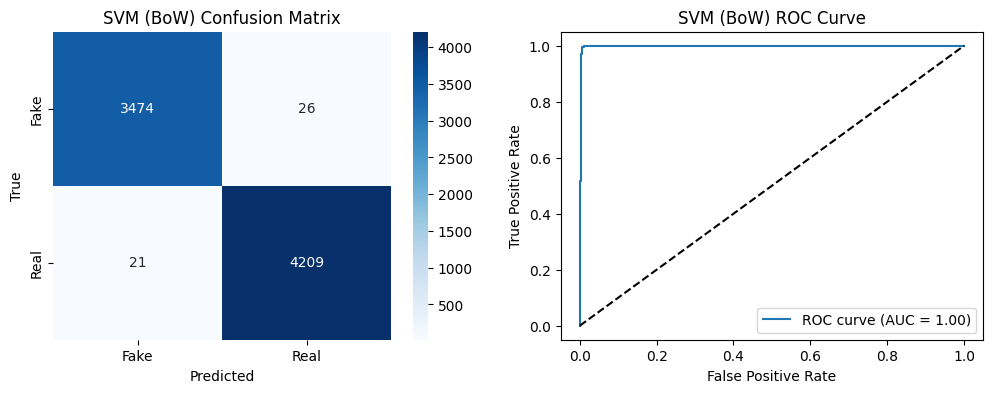

In [39]:
metrics=evaluate(svm_bow, X_test_bow, y_test, "SVM (BoW)")
results.append(metrics)

<b> Metrics of SVM using TF-IDF


SVM (TF-IDF) Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3500
           1       0.99      1.00      0.99      4230

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



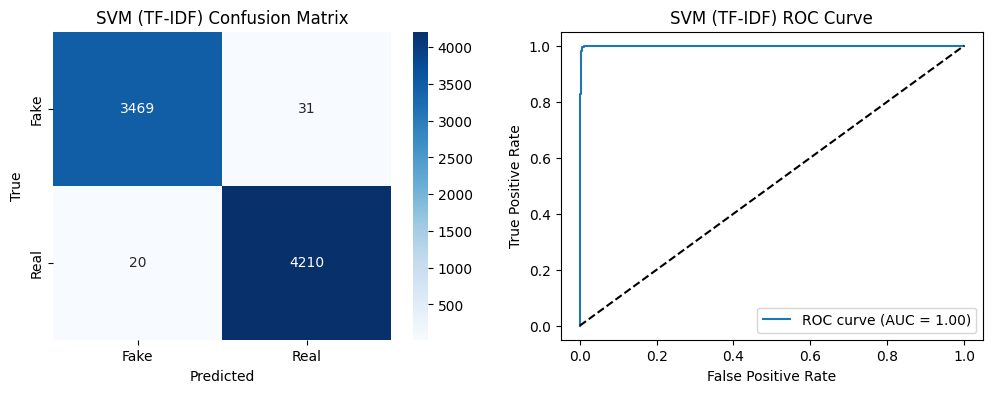

In [40]:
metrics=evaluate(svm_tfidf, X_test_tfidf, y_test, "SVM (TF-IDF)")
results.append(metrics)

## Comparitive Analysis

Both SVM modelsignificantly outperformed Naive Bayes across all metrics, achieving near-perfect accuracy (above 0.99), F1-score, and ROC AUC.

In [41]:
df_results = pd.DataFrame(results)
df_results = df_results[["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"]]  # reorder columns
print(df_results)

                  Model  Accuracy  Precision    Recall  F1-score   ROC AUC
0     Naive Bayes (BoW)  0.946313   0.956231  0.945154  0.950660  0.975382
1  Naive Bayes (TF-IDF)  0.936352   0.924966  0.961702  0.942976  0.981883
2             SVM (BoW)  0.993920   0.993861  0.995035  0.994448  0.997948
3          SVM (TF-IDF)  0.993402   0.992690  0.995272  0.993979  0.999042


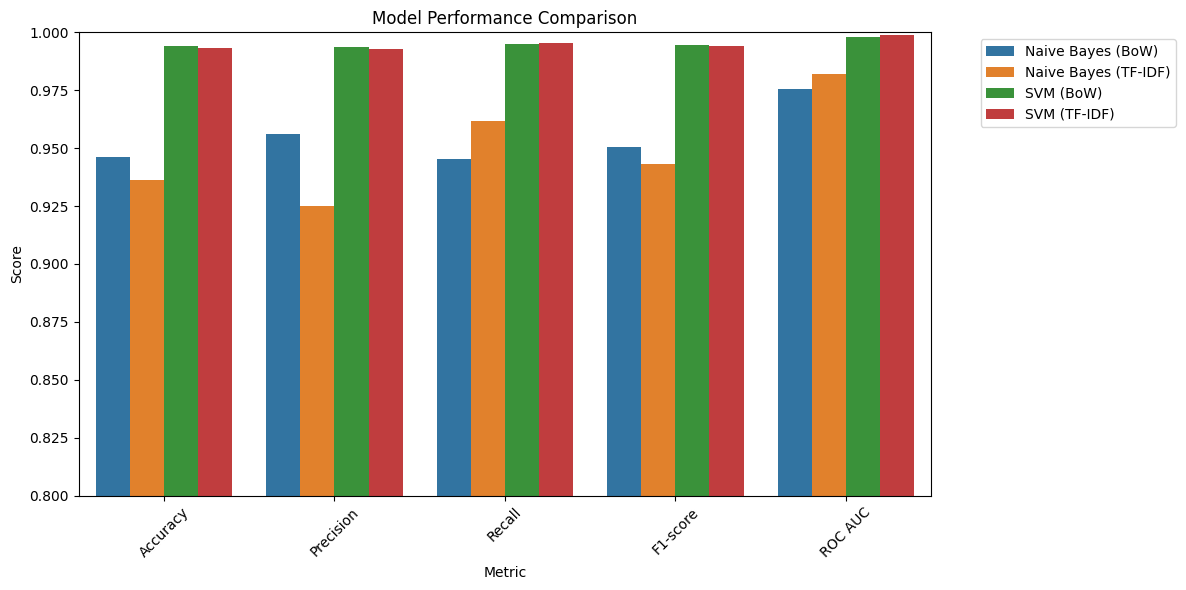

In [42]:
# Melt DataFrame for easy plotting
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Other Plots

<b>Top 30 Most Frequent Tokens

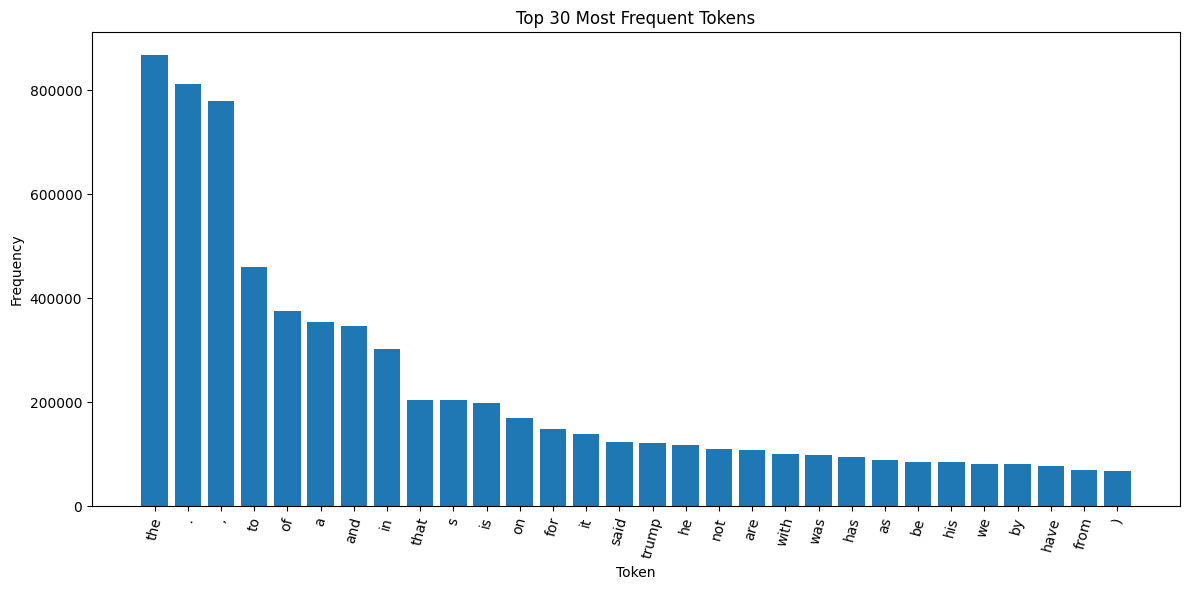

In [43]:
# Flatten all tokens
all_tokens = ' '.join(df['processed_text']).split()
token_freq = Counter(all_tokens)

# Top 50 tokens
common_tokens = token_freq.most_common(30)
tokens, freqs = zip(*common_tokens)

plt.figure(figsize=(12, 6))
plt.bar(tokens, freqs)
plt.xticks(rotation=75)
plt.title("Top 30 Most Frequent Tokens")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

REmoving stopwords to only visualize important words in wordcloud

In [44]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>WordCloud of the processed text without stopwords

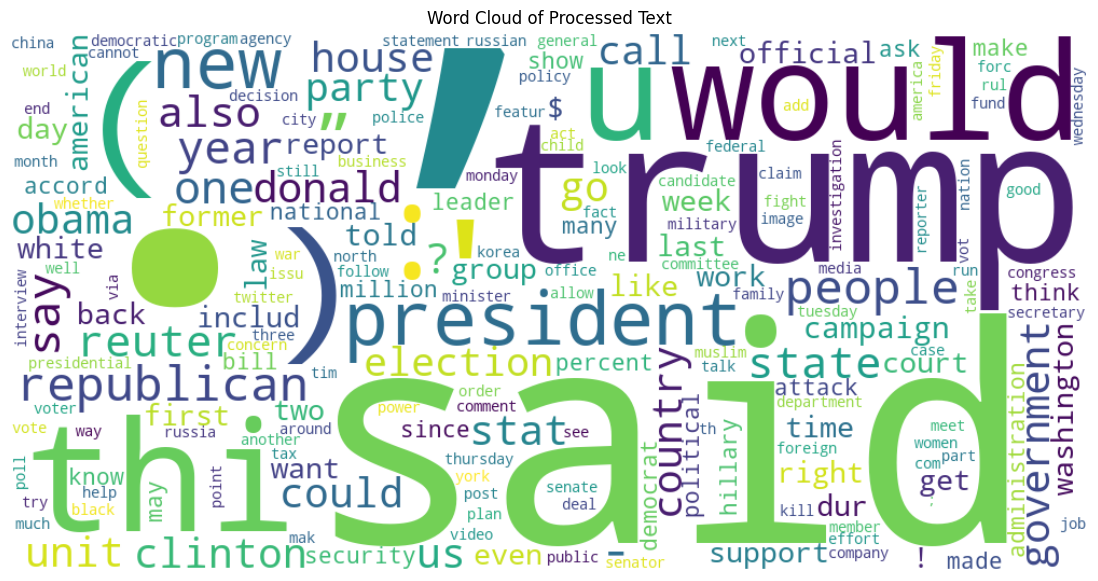

In [45]:
stop_words = set(stopwords.words('english'))

filtered_tokens = [token for token in all_tokens if token.lower() not in stop_words]

freq = Counter(filtered_tokens)

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(freq)


plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()

<b>Distribution of REPEAT tokens

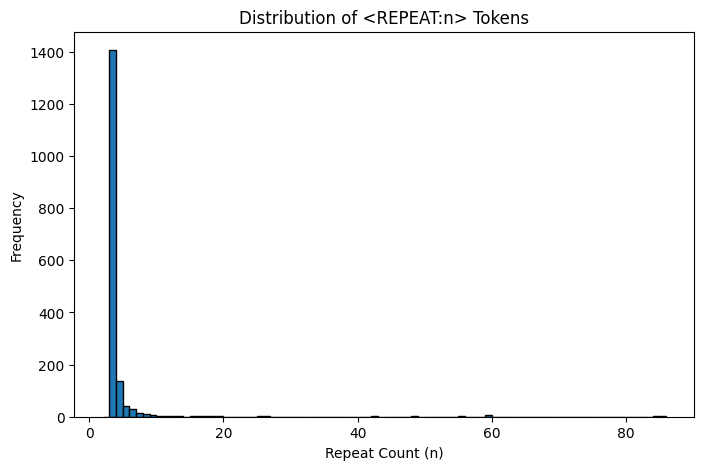

In [46]:
repeat_tokens = [t for t in all_tokens if re.fullmatch(r"<repeat:\d+>", t)]
repeats = [int(re.search(r"\d+", t).group()) for t in repeat_tokens]

if repeats:
    plt.figure(figsize=(8, 5))
    plt.hist(repeats, bins=range(2, max(repeats) + 2), edgecolor='black')
    plt.title("Distribution of <REPEAT:n> Tokens")
    plt.xlabel("Repeat Count (n)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No <REPEAT:n> tokens found in the data.")